# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Formulation of the optimal control problem: Pendubot

### Model description
<img src="https://raw.github.com/wiki/mayataka/CGMRES/images/fig_pendubot.png" width=25%>
The above figure shows the model of a pendubot. The equation of the motion can be derived by the Lagrange's method as
$$ \ddot{\theta}_1 = \ddot{\theta}_1 (\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ,$$
$$ \ddot{\theta}_2 = \ddot{\theta}_2 (\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) .$$
We ommit to describe its details here because it is too complicated.
We assume that the input of the pendubot is limited as  
$$u_{\rm min} \leq u \leq u_{\rm max} , $$
where $u_{\rm min}, u_{\rm max} \in \mathbb{R}$.

### Formulation of the optimal control problem
We define the state vector as
$$ x = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} .$$
The state equation is then given as 
$$\dot{x} = f(t, x, u) = \begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ \ddot{\theta}_1 (\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) \\ \ddot{\theta}_2 (\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) \end{bmatrix} .$$
To apply NMPC based on the C/GMRES method, we transform the inequality constraints into an equality constraint by introducing a virtual control input $u_{\rm dummy} \in \mathbb{R}$. The transformed equality constraint is then given by
$$C(t, x, u) = u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0, $$
where $u_{\rm dummy} \in \mathbb{R}$.  
Next, we set the cost function 
$$ J = \varphi(t, x) + \int_{t}^{t+T} L(t, x, u) .$$
The objective is to invert the pendubot and stabilize it. In other words, we want to converge the state of the pendubot to
$$x_{\rm ref} := \begin{bmatrix} \pi \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$  
To achieve this goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q_{\rm terminal} (x - x_{\rm ref}) ,$$  
where $Q_{\rm terminal} = {\rm diag}\left\{ {q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4 \right\}$ and ${q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4$ are positive real constants. We also set the stage cost as  
$$L(t, x, u) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q (x - x_{\rm ref}) + \frac{1}{2} r u^2 - r_{\rm dummy} u_{\rm dummy},$$  
where $Q = {\rm diag} \left\{ q_1, q_2, q_3, q_4 \right\}$ with positive real constants $q_1, q_2, q_3, q_4$, $r$ is positive real constant, and $r_{\rm dummy}$ is so, too. Note that the term $- r_{\rm dummy} u_{\rm dummy}$ is to determine the sign of $u_{\rm dummy}$ uniquely.


### Numerical solver of NMPC
In the following example, we compute the solution of NMPC using the multiple shooting based C/GMRES method with condensing of state and variables with respect to the constraints on the saturation of the control input. That is, $u_{\rm dummy}$ and $\mu$, the Lagrange multiplier associated with $C(t, x, u) = u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$ are condensed.

---

# Generate C++ codes of NMPC model  

## Import modules

In [1]:
from autogenu import autogenu

## Set dimensions and define `AutoGenU`
- `dimx`: Dimension of the state vector $x$   
- `dimu`: Dimension of the control input vector $u$  
- `model_name`: Name of the model. Used as the name of the directory containing the generated C++ source files.

In [2]:
dimx = 4
dimu = 1
model_name = 'pendubot'
ag = autogenu.AutoGenU(model_name, dimx, dimu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [3]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [4]:
# Variables used in the state function
m1, m2, l1, l2, d1, d2, J1, J2, g = ag.define_scalar_vars('m1', 'm2', 'l1', 'l2', 'd1', 'd2', 'J1', 'J2', 'g')

# Variables used in the cost function
q = ag.define_array_var('q', dimx)
q_terminal = ag.define_array_var('q_terminal', dimx)
x_ref = ag.define_array_var('x_ref', dimx)
r = ag.define_array_var('r', dimu)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [5]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [6]:
# Define the state equation
f = [x[2], 
     x[3],
     -(sin(x[0] + x[1]) * d2 * g * m2 + g * (d1 * m1 + l1 * m2) * sin(x[0]) - 0.2e1 * d2 * (x[2] + x[3] / 0.2e1) * l1 * x[3] * m2 * sin(x[1]) - u[0]) / (0.2e1 * d2 * m2 * l1 * cos(x[1]) + d1 * d1 * m1 + d2 * d2 * m2 + l1 * l1 * m2 + J1 + J2), 
     (g * d2 * l1 * m2 * (d1 * m1 + l1 * m2) * sin(x[0] - x[1]) / 0.2e1 - d2 * d2 * g * l1 * m2 * m2 * sin(x[0] + 0.2e1 * x[1]) / 0.2e1 - (d1 * d1 * m1 - d1 * l1 * m1 / 0.2e1 + l1 * l1 * m2 / 0.2e1 + J1) * m2 * g * d2 * sin(x[0] + x[1]) - l1 * l1 * m2 * m2 * d2 * d2 * (pow(x[2], 0.2e1) + x[2] * x[3] + pow(x[3], 0.2e1) / 0.2e1) * sin(0.2e1 * x[1]) - l1 * m2 * d2 * ((pow(x[2] + x[3], 0.2e1) * d2 * d2 + pow(x[2], 0.2e1) * l1 * l1) * m2 + (d1 * d1 * m1 + J1 + J2) * pow(x[2], 0.2e1) + 0.2e1 * J2 * x[2] * x[3] + J2 * pow(x[3], 0.2e1)) * sin(x[1]) + g * (d2 * d2 * l1 * m2 * m2 / 0.2e1 + (d1 * d2 * d2 * m1 + J2 * l1) * m2 + J2 * d1 * m1) * sin(x[0]) - u[0] * (d2 * m2 * l1 * cos(x[1]) + d2 * d2 * m2 + J2)) / (0.2e1 * d2 * m2 * l1 * cos(x[1]) + d1 * d1 * m1 + d2 * d2 * m2 + l1 * l1 * m2 + J1 + J2) / (d2 * d2 * m2 + J2)]

# Define the constraints
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = []
       
# Define the stage cost
L = sum(q[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2 + sum(r[i] * u[i]**2 for i in range(dimu))/2 

# Define the terminal cost
phi = sum(q_terminal[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2

In [7]:
# Set functions
ag.set_functions(f, C, h, L, phi)

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

In [8]:
ag.set_scalar_vars(['m1', 0.2], ['m2', 0.7], ['l1', 0.3], ['l2', 0.3], 
                   ['d1', 0.15], ['d2', 0.257], ['J1', 0.006], ['J2', 0.051], ['g', 9.80665])
ag.set_array_var('q', [1, 1, 0.1, 0.1])
ag.set_array_var('r', [0.1])
ag.set_array_var('q_terminal', [1, 1, 0.1, 0.1])
ag.set_array_var('x_ref', ['M_PI', 0, 0, 0])

## Generate C++ codes of NMPC model
Generate `nmpc_model.hpp` and `nmpc_model.cpp`, C++ source files of NMPC problem settings.  
- `use_simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `use_case`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `nmpc_model.cpp` is generated. Default is `False`. 

In [9]:
use_simplification = False
use_cse = True

ag.generate_source_files(use_simplification, use_cse)

---  
# Generate C++ codes for numerical simulation  

## Set solvers  
Set which solvers you use.
- `ContinuationGMRES` : The continuation/GMRES method (the original C/GMRES method, single shooting).
- `MultipleShootingCGMRES` : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `MSCGMRESWithInputSaturation` : The multiple shooting based C/GMRES method with condensing of the state, the Lagragne multipliers with respect to the state equation, and variables with respect to the constraints on the saturation function on the control input.   

Note that if you have to define the solver type as `autogenu.SolverType.ContinuationGMRES`, `autogenu.SolverType.MultipleShootingCGMRES`, or `autogenu.SolverType.MSCGMRESWithInputSaturation`

In [10]:
solver_type = autogenu.SolverType.MSCGMRESWithInputSaturation
ag.set_solver_type(solver_type)

## Set saturaions on the control input if you choose `MSCGMRESWithInputSaturation`
- Saturation on the control input: $u_{i, {\rm min}} \leq u_i \leq u_{i, {\rm max}}$  
$u_i \in \mathbb{R}$ : a constrained component of the control input $u$  
- Transformed equality constraint: $(u_i - \frac{u_{i, {\rm max}} + u_{i, {\rm min}}}{2})^2 - ( \frac{u_{i, {\rm max}} - u_{i, {\rm min}}}{2})^2 + {u_d}_i ^2 = 0$  
${u_d}_i \in \mathbb{R}$ : a dummy input for the transformation of the saturation into the equality constraint  
- Additional term in the stage cost $L(x, u)$ with respect to the saturation of $u_i$: $- {r_d}_i {u_d}_i + \frac{1}{2} {r_q}_i {u_d}_i ^2$  
   ${r_d}_i > 0$: a weight parameter to avoid failure of numerical computation, ${r_q}_i \geq 0$: a weight parameter to increase mergin of the saturation  

- Parameters:
    - `index`: $i$  
    - `u_min`: $u_{i, {\rm min}}$  
    - `u_max`: $u_{i, {\rm max}}$   
    - `dummy_weight`: ${r_d}_i > 0$  
    - `quadratic_weight` :  ${r_q}_i \geq 0$ 

In [11]:
# Add saturation_list as follows.
# ag.add_control_input_saturation(index , u_min, u_max, dummy_weight, quadratic_weight)
ag.add_control_input_saturation(0, -5, 5, 0.1, 0)

## Set parameters for the C/GMRES method

- `T_f`, `alpha`: Parameters for the length of the horizon $T(t)$: $T(t) = T_f (1 - e^{-\alpha t})$. The length of the horizon converges to `T_f` and the speed of the convergence is determied by `alpha`. 
- `N`: The division number of the horzion for the numerical computation.  
- `finite_difference_increment`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [12]:
T_f = 1.0
alpha = 1.0
N = 50
finite_difference_increment = 1.0e-08
zeta = 1000  
kmax = 3

ag.set_solver_parameters(T_f, alpha, N, finite_difference_increment, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `newton_residual_torelance`: The residual torelance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_newton_iteration`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  
- `initial_Lagrange_multiplier`: An optional parameter for `MSCGMRESWithInputSaturation`. This is a part of the initial guess of the solution, the initial guess of the Lagrange multiplier with respect the constraints on the saturation function of the control input. NOTE that this parameter has to be defined as list. If you do not specify this parameter, the all of initial Lagrange multiplier are set by 1e-03.

In [13]:
solution_initial_guess = [0.01]
newton_residual_torelance = 1.0e-06
max_newton_iteration = 50
initial_Lagrange_multiplier = [0.01]

ag.set_initialization_parameters(solution_initial_guess, newton_residual_torelance, max_newton_iteration, 
                                 initial_Lagrange_multiplier)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_time`: Simulation time of the numerical simulation.  
- `sampling_time`: The sampling time of the numerical simulation.

In [14]:
initial_time = 0  
initial_state = [0, 0, 0, 0]  
simulation_time = 10
sampling_time = 0.001  

ag.set_simulation_parameters(initial_time, initial_state, simulation_time, sampling_time)

## Generate main.cpp and CMakeLists.txt

In [15]:
ag.generate_main()
ag.generate_cmake()

## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [16]:
generator = 'Auto'  
remove_build_dir = False
ag.build(generator, remove_build_dir)
ag.run_simulation()

-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/autogenu-jupyter/models/pendubot/build


Scanning dependencies of target ms_cgmres_with_input_saturation
[  5%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/ms_cgmres_with_input_saturation.cpp.o
[ 11%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/ms_continuation_with_input_saturation.cpp.o
[ 16%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/ms_ocp_with_input_saturation.cpp.o
[ 22%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/ms_cgmres_with_input_saturation_initializer.cpp.o
[ 27%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/zero_horizon_ocp_with_input_saturation.cpp.o
[ 33%] Building CXX object CMakeFiles/ms_cgmres_with_input_saturation.dir/src/optimal_control_problem.cpp.o
[ 38%] Linking CXX static library libms_cgmres_with_input_saturation.a
[ 66%] Built target m

## Plot the simulation results

In [17]:
import autogenu.simulation_plottor as simplot

The graph of the simlation results is generated at models/pendubot/simulation_result/pendubot.pdf



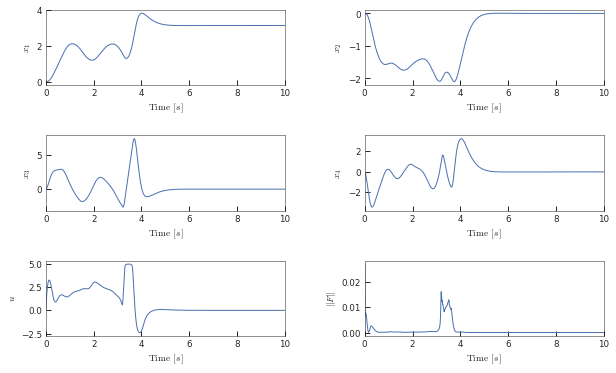

In [18]:
plot = simplot.SimulationPlottor(model_name)
plot.set_scales(2,5,2)
# plot.show_plots()
plot.save_plots()

## Draw animations of the simulation results

In [19]:
import autogenu.animation_generator as animgen

The animation of the simlation results is generated at models/pendubot/simulation_result/pendubot.mp4



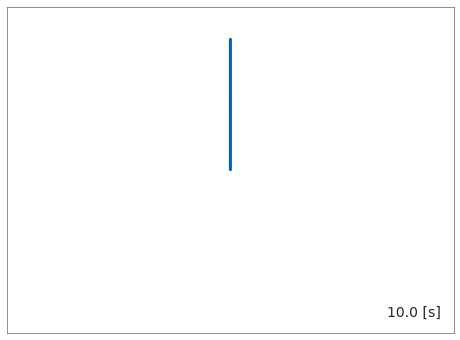

In [20]:
anim = animgen.TwoLinkArm(model_name)
anim.set_skip_frames(10)
anim.generate_animation()